1. Setcup the colab and download the data

In [ ]:
from google.colab import files, drive
files.upload()                              # choose kaggle.json
!mkdir -p ~/.kaggle && mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!pip install -q kaggle

Saving kaggle.json to kaggle.json


In [ ]:
!kaggle datasets download -d paultimothymooney/breast-histopathology-images
!unzip -q breast-histopathology-images.zip

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/breast-histopathology-images
License(s): CC0-1.0
 99% 3.06G/3.10G [00:27<00:00, 128MB/s] 
100% 3.10G/3.10G [00:27<00:00, 120MB/s]


In [ ]:
ls -ltr

total 3249988
-rw-r--r--   1 root root 3326820824 Sep 25  2019 breast-histopathology-images.zip
drwxr-xr-x   1 root root       4096 Jul 10 13:35 sample_data/
drwxr-xr-x   4 root root       4096 Jul 12 06:44 10253/
drwxr-xr-x   4 root root       4096 Jul 12 06:44 10254/
drwxr-xr-x   4 root root       4096 Jul 12 06:44 10255/
drwxr-xr-x   4 root root       4096 Jul 12 06:44 10256/
drwxr-xr-x   4 root root       4096 Jul 12 06:44 10257/
drwxr-xr-x   4 root root       4096 Jul 12 06:44 10258/
drwxr-xr-x   4 root root       4096 Jul 12 06:44 10259/
drwxr-xr-x   4 root root       4096 Jul 12 06:44 10260/
drwxr-xr-x   4 root root       4096 Jul 12 06:44 10261/
drwxr-xr-x   4 root root       4096 Jul 12 06:44 10262/
drwxr-xr-x   4 root root       4096 Jul 12 06:44 10264/
drwxr-xr-x   4 root root       4096 Jul 12 06:44 10268/
drwxr-xr-x   4 root root       4096 Jul 12 06:44 10269/
drwxr-xr-x   4 root root       4096 Jul 12 06:44 10272/
drwxr-xr-x   4 root root       4096 Jul 12 06:44 10273/
dr

In [ ]:
!ls dataset_split/train/0 | wc -l

ls: cannot access 'dataset_split/train/0': No such file or directory
0


In [ ]:
import os, random, shutil, pathlib
from tqdm import tqdm

SRC = pathlib.Path("/content/") # Updated SRC path
DEST = pathlib.Path("dataset_split")

for split in ("train", "val", "test"):
    for cls in ("0", "1"):
        (DEST/split/cls).mkdir(parents=True, exist_ok=True)

samples_per_class = {"train": 8000, "val": 1000, "test": 1000}

for cls in ("0", "1"):
    all_imgs = []
    # Walk through the patient directories
    for patient_dir in os.listdir(SRC):
        patient_path = os.path.join(SRC, patient_dir)
        if os.path.isdir(patient_path) and patient_dir.isdigit(): # Added check if patient_dir is a digit
            class_path = os.path.join(patient_path, cls)
            if os.path.isdir(class_path):
                for file in os.listdir(class_path):
                    if file.endswith(".png"):
                        all_imgs.append(os.path.join(class_path, file))

    print(f"Found {len(all_imgs)} images for class {cls}") # Debugging line

    random.shuffle(all_imgs)
    start = 0
    for split in ("train", "val", "test"):
        k = samples_per_class[split]
        subset = all_imgs[start:start+k]
        print(f"Attempting to copy {len(subset)} images for {split}/{cls}") # Debugging line
        for p in tqdm(subset, desc=f"Copy {split}/{cls}"):
            try:
                shutil.copy(p, DEST/split/cls/os.path.basename(p))
            except Exception as e:
                print(f"Error copying file {p}: {e}") # Debugging line
        start += k

Found 198738 images for class 0
Attempting to copy 8000 images for train/0


Copy train/0: 100%|██████████| 8000/8000 [00:13<00:00, 587.72it/s]


Attempting to copy 1000 images for val/0


Copy val/0: 100%|██████████| 1000/1000 [00:01<00:00, 594.72it/s]


Attempting to copy 1000 images for test/0


Copy test/0: 100%|██████████| 1000/1000 [00:01<00:00, 574.30it/s]


Found 78786 images for class 1
Attempting to copy 8000 images for train/1


Copy train/1: 100%|██████████| 8000/8000 [00:13<00:00, 612.86it/s]


Attempting to copy 1000 images for val/1


Copy val/1: 100%|██████████| 1000/1000 [00:01<00:00, 719.02it/s]


Attempting to copy 1000 images for test/1


Copy test/1: 100%|██████████| 1000/1000 [00:01<00:00, 669.47it/s]


In [ ]:
!ls dataset_split/train/0 | wc -l

8000


2. Load and  Preprocess the Data

The data source is the "breast-histopathology-images dataset" from Kaggle (https://www.kaggle.com/datasets/paultimothymooney/breast-histopathology-images). The original image size is 50x50.




In [ ]:
import tensorflow as tf
import pathlib

DEST = pathlib.Path("dataset_split") # Define DEST as it's used in the ImageDataGenerator code

IMG_SIZE = (50, 50)
BATCH = 64 # Increased batch size as suggested in the user's code

train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=10,
    validation_split=0.0)

train_ds = train_gen.flow_from_directory(
    DEST/"train", target_size=IMG_SIZE, batch_size=BATCH, class_mode='binary')

val_ds = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255).flow_from_directory(
    DEST/"val", target_size=IMG_SIZE, batch_size=BATCH, class_mode='binary')

test_ds = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255).flow_from_directory(
    DEST/"test", target_size=IMG_SIZE, batch_size=BATCH, class_mode='binary', shuffle=False)

print("Training dataset created with data augmentation.")
print("Validation dataset created.")
print("Test dataset created.")

Found 16000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Training dataset created with data augmentation.
Validation dataset created.
Test dataset created.


3. Define and Compile the Model

In [ ]:
from tensorflow.keras import layers, models

IMG_SIZE = (50, 50) # Define IMG_SIZE here as it's used in the model definition

model = models.Sequential([
    layers.Input(shape=(*IMG_SIZE, 3)),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 22, 22, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 11, 11, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 9, 9, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 355,649 (1.36 MB)

 Trainable params: 355,649 (1.36 MB)

 Non-trainable params: 0 (0.00 B)

4. Train the Model

In [ ]:
EPOCHS = 20 # You can adjust the number of epochs

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)

print("Model training complete.")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step - accuracy: 0.6582 - loss: 0.6090

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


250/250 ━━━━━━━━━━━━━━━━━━━━ 90s 349ms/step - accuracy: 0.6584 - loss: 0.6089 - val_accuracy: 0.7935 - val_loss: 0.4710
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 85s 340ms/step - accuracy: 0.7528 - loss: 0.5345 - val_accuracy: 0.7870 - val_loss: 0.4672
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 85s 338ms/step - accuracy: 0.7824 - loss: 0.4852 - val_accuracy: 0.7935 - val_loss: 0.4623
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 86s 342ms/step - accuracy: 0.7870 - loss: 0.4701 - val_accuracy: 0.8075 - val_loss: 0.4272
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 84s 337ms/step - accuracy: 0.7911 - loss: 0.4646 - val_accuracy: 0.8050 - val_loss: 0.4218
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 142s 339ms/step - accuracy: 0.7983 - loss: 0.4527 - val_accuracy: 0.8115 - val_loss: 0.4082
Epoch 7/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 87s 348ms/step - accuracy: 0.8009 - loss: 0.4490 - val_accuracy: 0.8040 - val_loss: 0.4369
Epoch 8/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 87s 349ms/step - accuracy: 0.7972 - loss: 0.4530 - va

In [ ]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test accuracy: {test_acc:.3f}")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 0.8802 - loss: 0.2887
Test accuracy: 0.822


6. Interpret Results with Additional Metrics

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 163ms/step


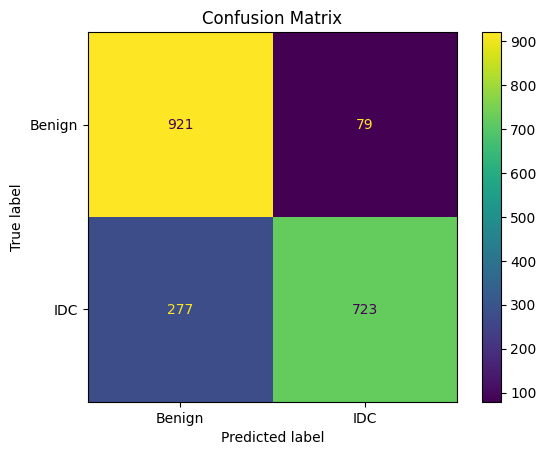

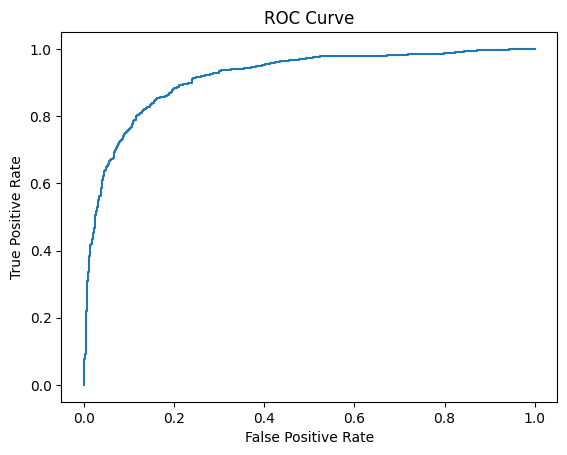

AUC: 0.9162229999999999


In [ ]:
import sklearn.metrics as skm, matplotlib.pyplot as plt
import numpy as np # Import numpy for array manipulation

# Get the true labels from the test dataset
y_true = test_ds.classes

# Get the predicted probabilities from the model
y_pred_prob = model.predict(test_ds).ravel()

# Convert predicted probabilities to binary predictions using a threshold (e.g., 0.5)
y_pred = (y_pred_prob > 0.5).astype(int) # Convert boolean to integer (0 or 1)

# Confusion Matrix
cm = skm.confusion_matrix(y_true, y_pred)
disp = skm.ConfusionMatrixDisplay(cm, display_labels=['Benign','IDC'])
disp.plot()
plt.title('Confusion Matrix')
plt.show()

# ROC Curve
fpr, tpr, _ = skm.roc_curve(y_true, y_pred_prob) # Use probabilities for ROC curve
plt.plot(fpr, tpr); plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curve'); plt.show()

# AUC Score
print("AUC:", skm.roc_auc_score(y_true, y_pred_prob)) # Use probabilities for AUC score

7. Save the Model

In [ ]:
import os

# Define the directory to save the model
model_save_dir = "saved_model"
os.makedirs(model_save_dir, exist_ok=True)

# Save the model
model.export(model_save_dir)

print(f"Model saved to: {model_save_dir}")

Saved artifact at 'saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 50, 50, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  135057055964368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135057055966096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135057055965712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135057055968976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135057055968208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135057055969936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135057055969360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135057055970320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135057055970704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135057055972240: TensorSpec(shape=(), dtype=tf.resource, name=None)
Model saved to: saved_m

8. Make Predictions

In [ ]:
import tensorflow as tf
import numpy as np

# Load the saved model
loaded_model = tf.saved_model.load("saved_model")

# Get the concrete function for inference
infer = loaded_model.signatures["serving_default"]

# Get a batch of images and labels from the test dataset
# Iterate over the test_ds DirectoryIterator to get a batch
for images, labels in test_ds:
    # Make predictions
    # The input to the serving_default signature expects a tensor
    # Ensure the images tensor is float32 as expected by the model
    predictions = infer(tf.cast(images, tf.float32))

    # The output of the serving_default signature is a dictionary of tensors
    # The predictions are usually under a key like 'output_0' or similar
    # We need to find the correct output tensor
    # Let's assume the output key is 'output_0' based on typical SavedModel structure
    # If this key is incorrect, we might need to inspect the loaded model's signatures
    predicted_output_tensor = None
    for key, value in predictions.items():
        # Assuming the prediction output is a float tensor with shape (batch_size, 1)
        if value.dtype == tf.float32 and value.shape.as_list()[-1] == 1:
             predicted_output_tensor = value
             break

    if predicted_output_tensor is not None:
        predictions = predicted_output_tensor
        # Process only the first batch for demonstration
        break
    else:
        print("Could not find the expected prediction output tensor in the model signature output.")
        predictions = None # Set predictions to None if the expected tensor is not found


if predictions is not None:
    # The predictions will be probabilities (due to the sigmoid activation)
    # You can convert them to class labels (0 or 1) using a threshold (e.g., 0.5)
    predicted_classes = (predictions > 0.5).numpy().astype(int)

    print("Original labels (first batch):")
    print(labels)
    print("\nPredicted classes (first batch):")
    print(predicted_classes.flatten()) # Flatten for easier comparison

    # Optional: Display the first few images and their predictions
    # Note: This part is for visualization and requires matplotlib
    # import matplotlib as plt
    # plt.figure(figsize=(10, 10))
    # for i in range(min(9, images.shape[0])): # Display up to 9 images or the number in the batch
    #     ax = plt.subplot(3, 3, i + 1)
    #     # ImageDataGenerator provides images already rescaled, so no need to convert to uint8 if model expects float
    #     # If displaying, might need to un-normalize or handle float display depending on matplotlib settings
    #     plt.imshow(images[i].numpy()) # Display as float image
    #     # Ensure labels and predictions are correctly indexed
    #     true_label = labels[i]
    #     pred_label = predicted_classes.flatten()[i]
    #     plt.title(f"True: {true_label}, Pred: {pred_label}")
    #     plt.axis("off")
    # plt.show()

else:
    print("Prediction could not be processed due to missing output tensor.")

Original labels (first batch):
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

Predicted classes (first batch):
[1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Model output keys: dict_keys(['output_0'])
Original labels (first batch):
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

Predicted classes (first batch):
[0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


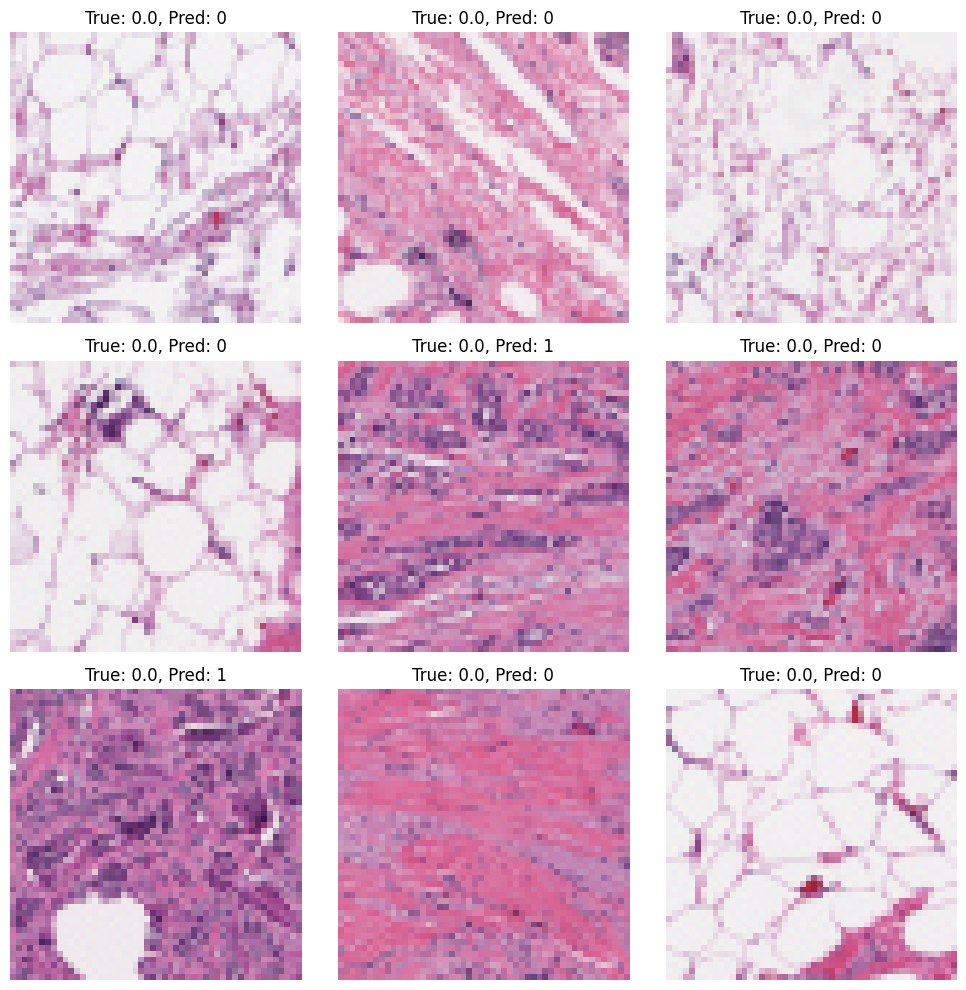

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Load the saved model
loaded_model = tf.saved_model.load("saved_model")

# Get the concrete function for inference
infer = loaded_model.signatures["serving_default"]

# Inspect available output keys (optional debug)
print("Model output keys:", infer.structured_outputs.keys())

# Get a batch of images and labels from the test dataset
for images, labels in test_ds:
    predictions = infer(tf.cast(images, tf.float32))  # Ensure float32 input

    predicted_output_tensor = None
    for key, value in predictions.items():
        if value.dtype == tf.float32 and value.shape[-1] == 1:
            predicted_output_tensor = value
            break

    if predicted_output_tensor is not None:
        predictions = predicted_output_tensor
        break
    else:
        print("Could not find the expected prediction output tensor.")
        predictions = None

if predictions is not None:
    predicted_classes = (predictions > 0.5).numpy().astype(int)

    print("Original labels (first batch):")
    print(labels)

    print("\nPredicted classes (first batch):")
    print(predicted_classes.flatten())

    # Visualization
    plt.figure(figsize=(10, 10))
    for i in range(min(9, images.shape[0])):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])  # Removed .numpy()
        true_label = labels[i]
        pred_label = predicted_classes.flatten()[i]
        plt.title(f"True: {true_label}, Pred: {pred_label}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()
else:
    print("Prediction could not be processed due to missing output tensor.")

9.Testing the Model with Rendom Imgaes

In [ ]:
from google.colab import files
uploaded = files.upload()  # Choose your custom test image file

Saving 9382_idx5_x1151_y1601_class1.png to 9382_idx5_x1151_y1601_class1.png


10. Load and Preprocess the Image

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np

IMG_SIZE = (50, 50)

# Replace 'your_image.png' with the actual file name uploaded
img_path = list(uploaded.keys())[0]  # automatically get uploaded filename
img = image.load_img(img_path, target_size=IMG_SIZE)
img_array = image.img_to_array(img)
img_array = img_array / 255.0  # normalize if your model was trained with rescaling
img_array = np.expand_dims(img_array, axis=0)  # add batch dimension

11. Run Prediction

In [ ]:
# Use the loaded model (already loaded earlier)
predictions = infer(tf.constant(img_array, dtype=tf.float32))

# Get the output tensor
predicted_output_tensor = None
for key, value in predictions.items():
    if value.dtype == tf.float32 and value.shape[-1] == 1:
        predicted_output_tensor = value
        break

if predicted_output_tensor is not None:
    prediction_prob = predicted_output_tensor.numpy()[0][0]
    predicted_class = 1 if prediction_prob > 0.5 else 0
    label = "IDC (Cancer)" if predicted_class == 1 else "Benign (No Cancer)"

    print(f"Prediction Probability: {prediction_prob:.4f}")
    print(f"Predicted Class: {label}")
else:
    print("Could not find the expected prediction output tensor.")

Prediction Probability: 0.5163
Predicted Class: IDC (Cancer)


12. Display the Image with Result

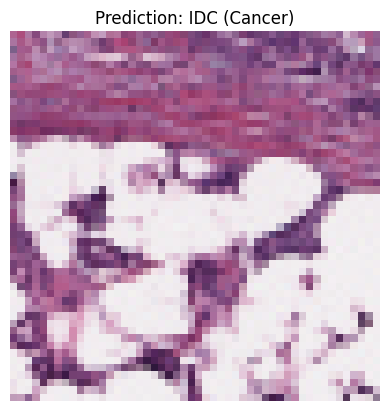

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(img)
plt.title(f"Prediction: {label}")
plt.axis('off')
plt.show()

13. Another Prediction

In [ ]:
from google.colab import files
uploaded = files.upload()  # Choose your custom test image file

Saving 9382_idx5_x1001_y1001_class0.png to 9382_idx5_x1001_y1001_class0 (2).png


In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np

IMG_SIZE = (50, 50)

# Replace 'your_image.png' with the actual file name uploaded
img_path = list(uploaded.keys())[0]  # automatically get uploaded filename
img = image.load_img(img_path, target_size=IMG_SIZE)
img_array = image.img_to_array(img)
img_array = img_array / 255.0  # normalize if your model was trained with rescaling
img_array = np.expand_dims(img_array, axis=0)  # add batch dimension

In [ ]:
# Use the loaded model (already loaded earlier)
predictions = infer(tf.constant(img_array, dtype=tf.float32))

# Get the output tensor
predicted_output_tensor = None
for key, value in predictions.items():
    if value.dtype == tf.float32 and value.shape[-1] == 1:
        predicted_output_tensor = value
        break

if predicted_output_tensor is not None:
    prediction_prob = predicted_output_tensor.numpy()[0][0]
    predicted_class = 1 if prediction_prob > 0.5 else 0
    label = "IDC (Cancer)" if predicted_class == 1 else "Benign (No Cancer)"

    print(f"Prediction Probability: {prediction_prob:.4f}")
    print(f"Predicted Class: {label}")
else:
    print("Could not find the expected prediction output tensor.")

Prediction Probability: 0.2827
Predicted Class: Benign (No Cancer)


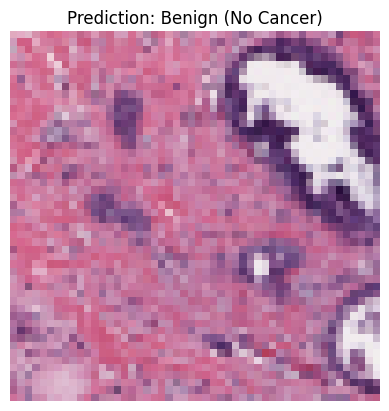

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(img)
plt.title(f"Prediction: {label}")
plt.axis('off')
plt.show()
